In [2]:
import numpy as np
import argparse
import copy
import torch
import torch.nn as nn
import time
from data.sparseloader import DataLoader
from data.data import LibSVMData, LibCSVData, LibSVMRegData
from data.sparse_data import LibSVMDataSp
#from models.mlp import MLP_1HL, MLP_2HL, MLP_3HL
from models.dynamic_net import DynamicNet, ForwardType
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.optim import SGD, Adam
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### grownet regressor에 필요한 함수 정의

In [3]:
# get_data: dataset을 load하는 함수
def get_data(tr, te, feat_d, normalization, cv):
    train = LibSVMRegData(tr, feat_d, normalization)
    test = LibSVMRegData(te, feat_d, normalization)
    val = []
    if cv:
        val = copy.deepcopy(train)
        print('Creating Validation set! \n')
        indices = list(range(len(train)))
        cut = int(len(train)*0.95)
        np.random.shuffle(indices)
        train_idx = indices[:cut]
        val_idx = indices[cut:]

        train.feat = train.feat[train_idx]
        train.label = train.label[train_idx]
        val.feat = val.feat[val_idx]
        val.label = val.label[val_idx]

        
    if normalization:
        scaler = StandardScaler()
        scaler.fit(train.feat)
        train.feat = scaler.transform(train.feat)
        test.feat = scaler.transform(test.feat)
        if cv:
            val.feat = scaler.transform(val.feat)
    print(f'#Train: {len(train)}, #Val: {len(val)} #Test: {len(test)}')
    return train, test, val

# get_optim: optimizer를 불러오는 함수
def get_optim(params, lr, weight_decay):
    optimizer = Adam(params, lr, weight_decay=weight_decay)
    #optimizer = SGD(params, lr, weight_decay=weight_decay)
    return optimizer

# root_mse: rmse를 계산하는 함수
def root_mse(net_ensemble, loader, cuda):
    loss = 0
    total = 0
 
    for x, y in loader:
        if cuda:
            x = x.cuda()

        with torch.no_grad():
            _, out = net_ensemble.forward(x)
        y = y.cpu().numpy().reshape(len(y), 1)
        out = out.cpu().numpy().reshape(len(y), 1)
        loss += mean_squared_error(y, out)* len(y)
        total += len(y)
    return np.sqrt(loss / total), out

# init_gbnn: 초기값을 지정하는 함수
def init_gbnn(train):
    positive = negative = 0
    for i in range(len(train)):
        if train[i][1] > 0:
            positive += 1
        else:
            negative += 1
    blind_acc = max(positive, negative) / (positive + negative)
    print(f'Blind accuracy: {blind_acc}')
    #print(f'Blind Logloss: {blind_acc}')
    return float(np.log(positive / negative))


# MLP_2HL: hidden layer가 2개인 mlp model을 만드는 클래스
class MLP_2HL(nn.Module):
    def __init__(self, dim_in, dim_hidden1, dim_hidden2, sparse=False, bn=True):
        super(MLP_2HL, self).__init__()
        self.in_layer = SpLinear(dim_in, dim_hidden1) if sparse else nn.Linear(dim_in, dim_hidden1)
        self.dropout_layer = nn.Dropout(0.0)
        self.lrelu = nn.LeakyReLU(0.1)
        self.relu = nn.ReLU()
        self.hidden_layer = nn.Linear(dim_hidden1, dim_hidden2)
        self.out_layer = nn.Linear(dim_hidden2, 1)
        self.bn = nn.BatchNorm1d(dim_hidden1)
        self.bn2 = nn.BatchNorm1d(dim_in)

    def forward(self, x, lower_f):
        if lower_f is not None:
            x = torch.cat([x, lower_f], dim=1)
            x = self.bn2(x)
        out = self.lrelu(self.in_layer(x))
        out = self.bn(out)
        out = self.hidden_layer(out)
        return out, self.out_layer(self.relu(out)).squeeze()

    @classmethod
    def get_model(cls, stage, feat_d, hidden_d, sparse):
        if stage == 0:
            dim_in = feat_d
        else:
            dim_in = feat_d + hidden_d
        model = MLP_2HL(dim_in, hidden_d, hidden_d, sparse)
        return model

### grownet_reg 함수 정의
grownet으로 회귀문제를 해결하는 함수
                
#### grownet_reg(feat_d, dataname, tr, te, out_f, hidden_d=32, boost_rate=1.0, lr=0.005, num_nets=40, batch_size=2048, epochs_per_stage=1, correct_epoch=1, L2=0.001, sparse=False, normalization=False, cv=False, cuda=False)
    <input>
    - feat_d: feature dimension (required)
    - datananme: 데이터 이름 지정 (required)
    - tr: npz 형식의 train 데이터 (required)
    - te: npz 형식의 test 데이터 (required)
    - out_f: 모델 저장 명. pth 형식 (required)
                
    <output>
    test y에 대한 예측값을 1차원 벡터 형식으로 반환

In [4]:
# Grownet regression을 실행하는 함수
def grownet_reg(feat_d, dataname, tr, te, out_f, 
                hidden_d=32, boost_rate=1.0, lr=0.005, num_nets=40, 
               batch_size=2048, epochs_per_stage=1, correct_epoch=1,
               L2=0.001, sparse=False, normalization=False, cv=False, cuda=False):
    '''
    <input>
    feat_d: feature dimension (required)
    datananme: 데이터 이름 지정 (required)
    tr: npz 형식의 train 데이터 (required)
    te: npz 형식의 test 데이터 (required)
    out_f: 모델 저장 명. pth 형식 (required)
    <output>
    test y에 대한 예측값을 1차원 벡터 형식으로 반환
    
    '''
    train, test, val = get_data(tr, te, feat_d, normalization, cv)
    N = len(train)
    print(dataname + ' training and test datasets are loaded!')
    train_loader = DataLoader(train, batch_size, shuffle=True, drop_last=False, num_workers=2)
    test_loader = DataLoader(test, len(test), shuffle=False, drop_last=False, num_workers=2)
    if cv:
        val_loader = DataLoader(val, batch_size, shuffle=True, drop_last=False, num_workers=2)
    best_rmse = pow(10, 6)
    val_rmse = best_rmse
    best_stage = num_nets-1
    c0 = np.mean(train.label)  #init_gbnn(train)
    net_ensemble = DynamicNet(c0, boost_rate)
    loss_f1 = nn.MSELoss()
    loss_models = torch.zeros((num_nets, 3))
    for stage in range(num_nets):
        t0 = time.time()
        model = MLP_2HL.get_model(stage, feat_d, hidden_d, sparse)  # Initialize the model_k: f_k(x), multilayer perception v2
        if cuda:
            model.cuda()
            
        optimizer = get_optim(model.parameters(), lr, L2)
        net_ensemble.to_train() # Set the models in ensemble net to train mode
        stage_mdlloss = []
        for epoch in range(epochs_per_stage):
            for i, (x, y) in enumerate(train_loader):
                
                if cuda:
                    x= x.cuda()
                    y = torch.as_tensor(y, dtype=torch.float32).cuda().view(-1, 1)
                middle_feat, out = net_ensemble.forward(x)
                if cuda:
                    out = torch.as_tensor(out, dtype=torch.float32).cuda().view(-1, 1)
                grad_direction = -(out-y)

                _, out = model(x, middle_feat)
                if cuda:
                    out = torch.as_tensor(out, dtype=torch.float32).cuda().view(-1, 1)
                loss = loss_f1(net_ensemble.boost_rate*out, grad_direction)  # T

                model.zero_grad()
                loss.backward()
                optimizer.step()
                stage_mdlloss.append(loss.item()*len(y))

        net_ensemble.add(model)
        sml = np.sqrt(np.sum(stage_mdlloss)/N)
        


        lr_scaler = 3
        # fully-corrective step
        stage_loss = []
        if stage > 0:
            # Adjusting corrective step learning rate 
            if stage % 15 == 0:
                #lr_scaler *= 2
                lr /= 2
                L2 /= 2
            optimizer = get_optim(net_ensemble.parameters(), lr / lr_scaler, L2)
            for _ in range(correct_epoch):
                stage_loss = []
                for i, (x, y) in enumerate(train_loader):
                    if cuda:
                        x, y = x.cuda(), y.cuda().view(-1, 1)
                    _, out = net_ensemble.forward_grad(x)
                    if cuda:
                        out = torch.as_tensor(out, dtype=torch.float32).cuda().view(-1, 1)
                    
                    loss = loss_f1(out, y) 
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    stage_loss.append(loss.item()*len(y))
        #print(net_ensemble.boost_rate)
        # store model
        elapsed_tr = time.time()-t0
        sl = 0
        if stage_loss != []:
            sl = np.sqrt(np.sum(stage_loss)/N)

        print(f'Stage - {stage}, training time: {elapsed_tr: .1f} sec, model MSE loss: {sml: .5f}, Ensemble Net MSE Loss: {sl: .5f}')

        net_ensemble.to_file(out_f)
        net_ensemble = DynamicNet.from_file(out_f, lambda stage: MLP_2HL.get_model(stage, feat_d, hidden_d, sparse))

        if cuda:
            net_ensemble.to_cuda()
        net_ensemble.to_eval() # Set the models in ensemble net to eval mode

        # Train
        tr_rmse, _ = root_mse(net_ensemble, train_loader, cuda)
        if cv:
            val_rmse, _ = root_mse(net_ensemble, val_loader, cuda) 
            if val_rmse < best_rmse:
                best_rmse = val_rmse
                best_stage = stage

        te_rmse, out = root_mse(net_ensemble, test_loader, cuda)
        
        print(f'Stage: {stage}  RMSE@Tr: {tr_rmse:.5f}, RMSE@Val: {val_rmse:.5f}, RMSE@Te: {te_rmse:.5f}')

        loss_models[stage, 0], loss_models[stage, 1] = tr_rmse, te_rmse

    tr_rmse, te_rmse = loss_models[best_stage, 0], loss_models[best_stage, 1]
    print(f'Best validation stage: {best_stage}  RMSE@Tr: {tr_rmse:.5f}, final RMSE@Te: {te_rmse:.5f}')
    loss_models = loss_models.detach().cpu().numpy()
    #out_csv = pd.DataFrame(out)
    #out_csv.to_csv(filename, index=False)
    fname =  './results/' + dataname +'_rmse'
    np.savez(fname, rmse=loss_models) 
    
    return pd.Series(np.reshape(out, -1))

In [1]:
#!pip install torch==1.8.1

## 데이터 load 및 가공
California housing data를 이용한 캘리포니아 집값 예측문제

In [5]:
data = pd.read_csv('housing.csv')

# 범주형 변수를 수치형으로 변환
le = LabelEncoder()
le = le.fit(data['ocean_proximity'])  
data['ocean_proximity'] = le.transform(data['ocean_proximity'])
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,3
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,3
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,3
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,3
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,3


In [7]:
# median house value가 500000보다 큰 데이터는 모두 500001로 기록됨 -> 분석에서 제외
data = data[data['median_house_value'] != 500001]

In [29]:
# na 처리
data.isnull().sum()   # na 확인

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [8]:
data = data.dropna(axis=0)   # na 값이 포함된 행은 제거

In [9]:
# train, test split 및 데이터 저장
# train, test split
X = data.drop('median_house_value', axis=1)
y = data['median_house_value']
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=777)

# save files
np.savez('train', labels = train_y, features = train_x )
np.savez('test', labels = test_y, features = test_x)

# 파일을 로드하여 잘 저장되었는지 확인
t = np.load('train.npz')
t['features']

array([[-1.1835e+02,  3.4050e+01,  5.2000e+01, ...,  4.0900e+02,
         3.6435e+00,  0.0000e+00],
       [-1.1702e+02,  3.2740e+01,  1.2000e+01, ...,  8.7900e+02,
         1.8594e+00,  4.0000e+00],
       [-1.1828e+02,  3.3740e+01,  4.0000e+01, ...,  5.0300e+02,
         1.5394e+00,  4.0000e+00],
       ...,
       [-1.2181e+02,  3.8580e+01,  1.7000e+01, ...,  2.8600e+02,
         5.9629e+00,  1.0000e+00],
       [-1.2242e+02,  3.7660e+01,  2.6000e+01, ...,  8.5500e+02,
         2.6631e+00,  4.0000e+00],
       [-1.2245e+02,  3.7740e+01,  4.6000e+01, ...,  1.1090e+03,
         5.0887e+00,  3.0000e+00]])

## Modeling

- case 1: grownet github에서 제공하는 default parameter 사용

In [12]:
pred_y = grownet_reg(feat_d=9, dataname='california', 
                     tr='train.npz', te='test.npz', out_f='california_model.pth')

9
9
#Train: 15580, #Val: 0 #Test: 3895
california training and test datasets are loaded!
Stage - 0, training time:  4.6 sec, model MSE loss:  97416.77851, Ensemble Net MSE Loss:  0.00000
Stage: 0  RMSE@Tr: 97416.53252, RMSE@Val: 1000000.00000, RMSE@Te: 98825.95287
Stage - 1, training time:  9.6 sec, model MSE loss:  97416.24536, Ensemble Net MSE Loss:  97415.35843
Stage: 1  RMSE@Tr: 97415.56999, RMSE@Val: 1000000.00000, RMSE@Te: 98825.03586
Stage - 2, training time:  9.3 sec, model MSE loss:  97414.38106, Ensemble Net MSE Loss:  97412.79322
Stage: 2  RMSE@Tr: 97413.02695, RMSE@Val: 1000000.00000, RMSE@Te: 98822.52828
Stage - 3, training time:  9.7 sec, model MSE loss:  97410.94779, Ensemble Net MSE Loss:  97408.53726
Stage: 3  RMSE@Tr: 97407.67956, RMSE@Val: 1000000.00000, RMSE@Te: 98817.20207
Stage - 4, training time:  10.3 sec, model MSE loss:  97405.61892, Ensemble Net MSE Loss:  97402.44855
Stage: 4  RMSE@Tr: 97396.81297, RMSE@Val: 1000000.00000, RMSE@Te: 98806.33113
Stage - 5, tra

In [13]:
pred_y

0       192118.687500
1       191500.890625
2       192541.000000
3       194378.046875
4       196460.453125
            ...      
3890    191929.468750
3891    191085.765625
3892    191463.546875
3893    191751.812500
3894    192477.718750
Length: 3895, dtype: float32

In [14]:
# RMSE 계산
np.sqrt(mean_squared_error(test_y, pred_y))

97529.89974494286

In [19]:
# pseudo-R^2 계산
def getpr2(testy, predy):
    result = 1 - sum((testy - predy)**2) / sum((testy - np.mean(testy))**2)
    return result

In [24]:
getpr2(test_y.reset_index(drop=True), pred_y)

0.025924854358532867

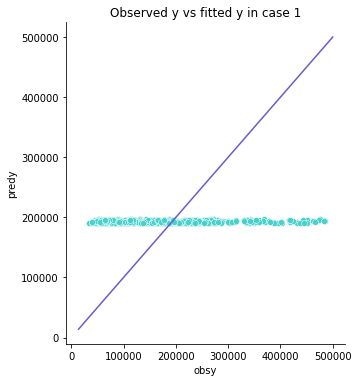

In [15]:
# Observed y vs fitted y
y_df = pd.DataFrame({'obsy':test_y, 'predy':pred_y})
sns.relplot(x='obsy', y='predy', data=y_df, color="mediumturquoise")
plt.plot([14000, 500010], [14000, 500010], color="slateblue")
plt.title("Observed y vs fitted y in case 1");

- case 2: 파라미터 조정

In [16]:
pred_y2 = grownet_reg(feat_d=9, dataname='california', 
                     tr='train.npz', te='test.npz', out_f='california_model.pth',
                     num_nets=90, lr=0.05, L2=.0e-7)

9
9
#Train: 15580, #Val: 0 #Test: 3895
california training and test datasets are loaded!
Stage - 0, training time:  4.1 sec, model MSE loss:  97412.60511, Ensemble Net MSE Loss:  0.00000
Stage: 0  RMSE@Tr: 97393.42226, RMSE@Val: 1000000.00000, RMSE@Te: 98805.04084
Stage - 1, training time:  8.5 sec, model MSE loss:  97386.63687, Ensemble Net MSE Loss:  97302.84350
Stage: 1  RMSE@Tr: 97315.86128, RMSE@Val: 1000000.00000, RMSE@Te: 98730.52780
Stage - 2, training time:  8.5 sec, model MSE loss:  97211.56221, Ensemble Net MSE Loss:  97053.17423
Stage: 2  RMSE@Tr: 96944.02589, RMSE@Val: 1000000.00000, RMSE@Te: 98364.78850
Stage - 3, training time:  8.4 sec, model MSE loss:  96834.73630, Ensemble Net MSE Loss:  96569.14642
Stage: 3  RMSE@Tr: 96206.16547, RMSE@Val: 1000000.00000, RMSE@Te: 97629.12615
Stage - 4, training time:  8.8 sec, model MSE loss:  96168.33757, Ensemble Net MSE Loss:  95748.97485
Stage: 4  RMSE@Tr: 94935.59757, RMSE@Val: 1000000.00000, RMSE@Te: 96346.10145
Stage - 5, trai

Stage - 45, training time:  10.3 sec, model MSE loss:  48153.30169, Ensemble Net MSE Loss:  48199.28092
Stage: 45  RMSE@Tr: 47720.53880, RMSE@Val: 1000000.00000, RMSE@Te: 50447.25404
Stage - 46, training time:  10.4 sec, model MSE loss:  47625.00948, Ensemble Net MSE Loss:  48088.23937
Stage: 46  RMSE@Tr: 48063.53172, RMSE@Val: 1000000.00000, RMSE@Te: 50925.14978
Stage - 47, training time:  10.3 sec, model MSE loss:  47684.62549, Ensemble Net MSE Loss:  47925.17186
Stage: 47  RMSE@Tr: 47865.93419, RMSE@Val: 1000000.00000, RMSE@Te: 51092.12385
Stage - 48, training time:  10.5 sec, model MSE loss:  47560.73431, Ensemble Net MSE Loss:  47803.64355
Stage: 48  RMSE@Tr: 47579.89502, RMSE@Val: 1000000.00000, RMSE@Te: 50787.99480
Stage - 49, training time:  10.6 sec, model MSE loss:  47531.92432, Ensemble Net MSE Loss:  47774.59559
Stage: 49  RMSE@Tr: 47430.85481, RMSE@Val: 1000000.00000, RMSE@Te: 50519.30768
Stage - 50, training time:  10.5 sec, model MSE loss:  47142.40064, Ensemble Net MSE 

In [25]:
# RMSE 계산
np.sqrt(mean_squared_error(test_y, pred_y2))

49028.117724067146

In [26]:
getpr2(test_y.reset_index(drop=True), pred_y2)

0.7538457452035265

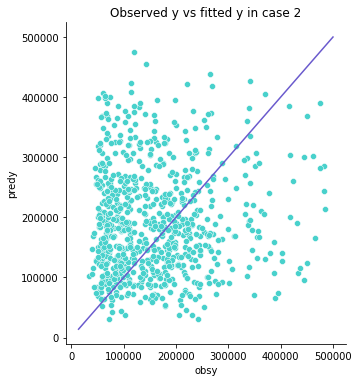

In [18]:
# Observed y vs fitted y
y_df = pd.DataFrame({'obsy':test_y, 'predy':pred_y2})
sns.relplot(x='obsy', y='predy', data=y_df, color="mediumturquoise")
plt.plot([14000, 500010], [14000, 500010], color="slateblue")
plt.title("Observed y vs fitted y in case 2");